# Desafio 03 - Modelo de lenguaje con tokenizacion - Char

In [1]:
import urllib.request
import bs4 as bs
from tensorflow.keras.utils import pad_sequences # se utilizará para padding
import numpy as np


from tensorflow import keras
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense, GRU, LSTM
from keras.models import Model, Sequential

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf

# Verifica si TensorFlow está utilizando GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Verifica los dispositivos disponibles y sus detalles
for device in tf.config.list_physical_devices():
    print(device)

Num GPUs Available:  1
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Para el desafío se utilizo el libro "veinte mil leguas de viaje submarino" de Julio Verne

In [3]:
url_libro = "https://www.textos.info/julio-verne/veinte-mil-leguas-de-viaje-submarino/ebook"

In [4]:
raw_html = urllib.request.urlopen(url_libro)
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

In [5]:
article_text[:1000]

' el año 1866 quedó caracterizado por un extraño acontecimiento, por un\r\n fenómeno inexplicable e inexplicado que nadie, sin duda, ha podido \r\nolvidar. sin hablar de los rumores que agitaban a las poblaciones de los\r\n puertos y que sobreexcitaban a los habitantes del interior de los \r\ncontinentes, el misterioso fenómeno suscitó una particular emoción entre\r\n los hombres del mar. negociantes, armadores, capitanes de barco, \r\nskippers y masters de europa y de américa, oficiales de la marina de \r\nguerra de todos los países y, tras ellos, los gobiernos de los \r\ndiferentes estados de los dos continentes, manifestaron la mayor \r\npreocupación por el hecho. desde hacía algún tiempo, en efecto, varios barcos se habían \r\nencontrado en sus derroteros con «una cosa enorme», con un objeto largo,\r\n fusiforme, fosforescente en ocasiones, infinitamente más grande y más \r\nrápido que una ballena. los hechos relativos a estas apariciones, consignados en los \r\ndiferentes libros d

In [6]:
#me quedo con la mitad del libro por problemas de memoria de GPU en colab
article_text = article_text[:len(article_text)//2]

## Utilizando caracteres

In [7]:
# seleccionamos el tamaño de contexto
max_context_size = 100
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

66

In [8]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

char2idx

{'7': 0,
 'f': 1,
 'r': 2,
 '4': 3,
 '2': 4,
 'v': 5,
 ' ': 6,
 '1': 7,
 'é': 8,
 ';': 9,
 's': 10,
 'y': 11,
 '»': 12,
 'á': 13,
 'g': 14,
 '¿': 15,
 '/': 16,
 'q': 17,
 'p': 18,
 '«': 19,
 'c': 20,
 '\n': 21,
 'j': 22,
 'u': 23,
 '"': 24,
 '\t': 25,
 'h': 26,
 ':': 27,
 '6': 28,
 '5': 29,
 ')': 30,
 'e': 31,
 '8': 32,
 'm': 33,
 'º': 34,
 '\r': 35,
 '!': 36,
 '.': 37,
 '—': 38,
 'o': 39,
 't': 40,
 '-': 41,
 '?': 42,
 '(': 43,
 'è': 44,
 'x': 45,
 'k': 46,
 "'": 47,
 '0': 48,
 'b': 49,
 'í': 50,
 'n': 51,
 'l': 52,
 'ó': 53,
 '¡': 54,
 '3': 55,
 ',': 56,
 'w': 57,
 'ü': 58,
 'ú': 59,
 'ñ': 60,
 'i': 61,
 '9': 62,
 'z': 63,
 'a': 64,
 'd': 65}

In [9]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [10]:
tokenized_text[:10]

[6, 31, 52, 6, 64, 60, 39, 6, 7, 32]

In [11]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

In [12]:
vocab_size = len(chars_vocab)

### Definicion de modelos SimpleRNN (celda de Elman), LSTM y GRU

In [13]:
#Simple RNN
model_RNN = Sequential()

model_RNN.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_RNN.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model_RNN.add(Dense(vocab_size, activation='softmax'))
model_RNN.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_RNN.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, None, 66)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, None, 200)           │          53,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 66)            │          13,266 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,666 (260.41 KB)

 Trainable params: 66,666 (260.41 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
#LSTM
model_LSTM = Sequential()

model_LSTM.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_LSTM.add(LSTM(150, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model_LSTM.add(Dense(vocab_size, activation='softmax'))
model_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_LSTM.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_1 (TimeDistributed) │ (None, None, 66)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, None, 150)           │         130,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, None, 66)            │           9,966 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 140,166 (547.52 KB)

 Trainable params: 140,166 (547.52 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
GRU
model_GRU = Sequential()

model_GRU.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_GRU.add(GRU(150, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model_GRU.add(Dense(vocab_size, activation='softmax'))
model_GRU.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_GRU.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_2 (TimeDistributed) │ (None, None, 66)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, None, 150)           │          98,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, None, 66)            │           9,966 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 108,066 (422.13 KB)

 Trainable params: 108,066 (422.13 KB)

 Non-trainable params: 0 (0.00 B)

Al mantener las 200 unidades en todos los modelos, tanto GRU como LSTM presentan una cantidad significativamente mayor de parámetros entrenables en comparación con el SimpleRNN. Este incremento en los parámetros se traduce en un tiempo de entrenamiento más prolongado. Por cuestiones prácticas del desafío se decidio utilizar 150 unidades para estos dos modelos.

### Entrenamientos

In [16]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5,model_name="model_lenguaje"):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data
      self.model_name = model_name
      self.history_ppl = history_ppl

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save(self.model_name)
          print(f"Saved new model! How {self.model_name}")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True

Por temas de que al estar trabajando en windows tensorflow ya no tiene soporte de GPU se decidio realizar el entrenamiento en google colab.

In [17]:
#entrenamiento simpleRNN
history_ppl_RNN = []
hist = model_RNN.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_RNN,model_name='model_RNN.keras')], batch_size=256)

Epoch 1/20
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.4287
 mean perplexity: 6.4383448220074255 

Saved new model! How model_RNN.keras
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 61s 34ms/step - loss: 2.4285
Epoch 2/20
1502/1505 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.9376
 mean perplexity: 5.67108469141527 

Saved new model! How model_RNN.keras
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - loss: 1.9375
Epoch 3/20
1503/1505 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.8329
 mean perplexity: 5.478664120641158 

Saved new model! How model_RNN.keras
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - loss: 1.8329
Epoch 4/20
1503/1505 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7857
 mean perplexity: 5.265857523679456 

Saved new model! How model_RNN.keras
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - loss: 1.7856
Epoch 5/20
1504/1505 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7595
 mean perplexity: 5.215499141136086 

Saved new model! How model_RNN.keras
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 40s 

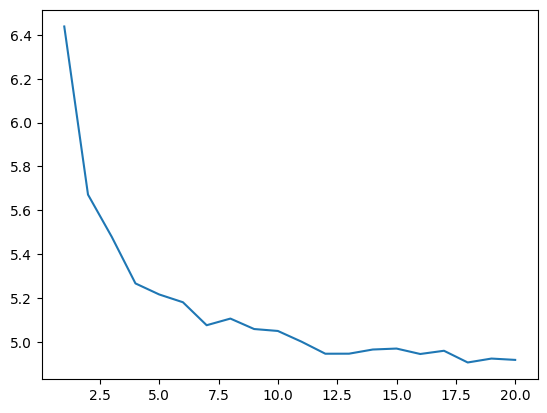

In [18]:
# Entrenamiento
epoch_count = range(1, len(history_ppl_RNN) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl_RNN)
plt.show()

In [19]:
#entrenamiento simpleRNN
history_ppl_LSTM = []
hist = model_LSTM.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_LSTM,model_name='model_LSTM.keras')], batch_size=256)

Epoch 1/20
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 2.7124
 mean perplexity: 8.538883301966559 

Saved new model! How model_LSTM.keras
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 219s 142ms/step - loss: 2.7122
Epoch 2/20
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 2.2069
 mean perplexity: 7.52877030424327 

Saved new model! How model_LSTM.keras
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 210s 139ms/step - loss: 2.2069
Epoch 3/20
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 2.1000
 mean perplexity: 7.031712022087519 

Saved new model! How model_LSTM.keras
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 208s 139ms/step - loss: 2.1000
Epoch 4/20
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 2.0285
 mean perplexity: 6.576632761478117 

Saved new model! How model_LSTM.keras
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 209s 139ms/step - loss: 2.0285
Epoch 5/20
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 1.9736
 mean perplexity: 6.242440022365103 

Saved new model! How model_LSTM.keras
1505/1505 ━━━━━━━━━━━━━

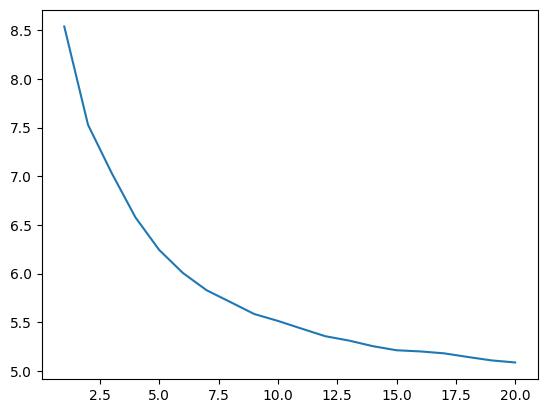

In [20]:
# Entrenamiento
epoch_count = range(1, len(history_ppl_LSTM) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl_LSTM)
plt.show()

In [21]:
#entrenamiento simpleRNN
history_ppl_GRU = []
hist = model_GRU.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_GRU,model_name='model_GRU.keras')], batch_size=256)

Epoch 1/20
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 2.5174
 mean perplexity: 6.532701812102739 

Saved new model! How model_GRU.keras
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 294s 192ms/step - loss: 2.5172
Epoch 2/20
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 1.9255
 mean perplexity: 5.553317523096321 

Saved new model! How model_GRU.keras
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 287s 190ms/step - loss: 1.9255
Epoch 3/20
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 1.7762
 mean perplexity: 5.193125909791489 

Saved new model! How model_GRU.keras
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 287s 191ms/step - loss: 1.7762
Epoch 4/20
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 1.7073
 mean perplexity: 4.990879689129141 

Saved new model! How model_GRU.keras
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 287s 191ms/step - loss: 1.7073
Epoch 5/20
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 1.6695
 mean perplexity: 4.8780874821673885 

Saved new model! How model_GRU.keras
1505/1505 ━━━━━━━━━━━

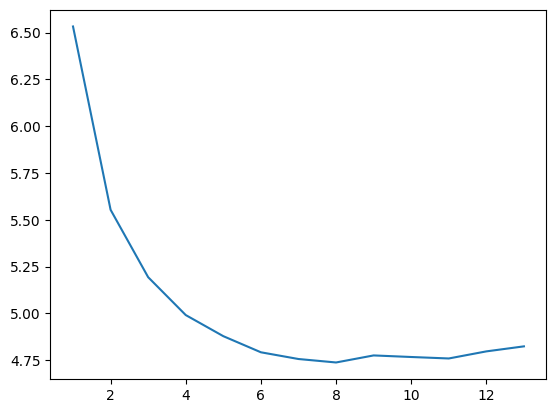

In [22]:
# Entrenamiento
epoch_count = range(1, len(history_ppl_GRU) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl_GRU)
plt.show()

Como se puede observar los 3 modelos tuvieron comportamientos similares. Sin embargo al ser modelos más complejos tanto LSTM como GRU obtuvieron mejores métricas durante el entrenamiento. Además se puede notar que un aumento en la cantidad de epocas podría conseguir mejores métricas en los mismos.

### Analitisis de resultados

In [23]:
#carga de los modelos
model_RNN = keras.models.load_model('model_RNN.keras')
model_LSTM = keras.models.load_model('model_LSTM.keras')
model_GRU = keras.models.load_model('model_GRU.keras')

In [25]:
def model_response(human_text, model_name):
    """
    Esta función recibe el texto de entrada del usuario y el nombre del modelo a utilizar.
    Genera una respuesta utilizando el modelo seleccionado.
    """

    models = {
        "SimpleRNN": model_RNN,
        "LSTM": model_LSTM,
        "GRU": model_GRU,
    }

    model = models[model_name]

    encoded = [char2idx[ch] for ch in human_text.lower()]
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    y_hat = np.argmax(model.predict(encoded)[0, -1, :])

    out_word = idx2char[y_hat]

    return human_text + out_word

In [26]:
texto_inicial = "Capitán Nem"
print(f'SimpleRNN: { model_response(texto_inicial, "SimpleRNN") }')
print(f'LSTM: {model_response(texto_inicial, "LSTM")}')
print(f'GRU: {model_response(texto_inicial, "GRU")}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
SimpleRNN: Capitán Nemo
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
LSTM: Capitán Nemo
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
GRU: Capitán Nemo


Como se puede observar los 3 modelos completaron correctamente el nombre del capitán.

In [27]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [40]:
input_text='El submarino desciende a las'

generate_seq(model_RNN, input_text, max_length=max_context_size, n_words=30)

'El submarino desciende a las continuas en la continuación '

In [41]:
generate_seq(model_LSTM, input_text, max_length=max_context_size, n_words=30)

'El submarino desciende a las paras de la continua de la co'

In [42]:
generate_seq(model_GRU, input_text, max_length=max_context_size, n_words=30)

'El submarino desciende a las continuados de la \r\ncontinuac'

En el caso de la generación de secuencias, se puede observar como los tres modelos no tienen un buen resultado. Esto se puede deber a la baja cantidad de datos utilizados para el entrenamiento, como a lo simple de los modelos utilizados.

#### beam_search

In [31]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [32]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [45]:
# predicción con beam search en modo determinista
texto_input = "el submarino desciende a las"
print(f"SimpleRNN: {decode(beam_search(model_RNN,num_beams=10,num_words=20,input=texto_input,temp=1,mode='det')[0])}")
print(f'LSTM: {decode(beam_search(model_LSTM,num_beams=10,num_words=20,input=texto_input,temp=1,mode="det")[0])}')
print(f'GRU: {decode(beam_search(model_GRU,num_beams=10,num_words=20,input=texto_input,temp=1,mode="det")[0])}')

SimpleRNN: el submarino desciende a las aguas como el capit
LSTM: el submarino desciende a las aguas del nautilus 
GRU: el submarino desciende a las profundidades de la


In [48]:
# predicción con beam search en modo est
texto_input = "el submarino desciende a las"
print(f"SimpleRNN, temp=3: {decode(beam_search(model_RNN,num_beams=10,num_words=20,input=texto_input,temp=2,mode='sto')[0])}")
print(f'LSTM, temp=3: {decode(beam_search(model_LSTM,num_beams=10,num_words=20,input=texto_input,temp=2,mode="sto")[0])}')
print(f'GRU, temp=3: {decode(beam_search(model_GRU,num_beams=10,num_words=20,input=texto_input,temp=2,mode="sto")[0])}')

SimpleRNN, temp=3: el submarino desciende a las profusion con sus t
LSTM, temp=3: el submarino desciende a las 
estos pocos desgn
GRU, temp=3: el submarino desciende a las invenios conseil, u


Para estos casos se puede ver que el modo determinista da resultados mucho más coherentes que el método stocastico. Aunque en el primer caso se encuentran inconsistencias como el decir "las aguas del nautilus" debido a que el mismo es un submarino.